# installation

In [26]:
%pip install pytorch-msssim

Defaulting to user installation because normal site-packages is not writeable


# Imports

In [27]:
import os
import wandb
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_sched
from torchinfo import summary
import torch.optim as optim
import random
import math
from tqdm import tqdm
import psutil
import torch.nn as nn

from typing import Dict

# metrics
from sklearn.metrics import roc_auc_score, accuracy_score

# Config

In [28]:
class CONFIG:
    BATCH_SIZE = 4
    
    # limit the data to prototype faster
    DATA_LIMIT = 200
    
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ROUND_NUMBER = 3
    TASK_NAME = "DeepLense2024_task2A"
    DATA_PATH = os.path.join("Data", "Superresolution")
    PORTION_OF_DATA_FOR_TRAINING = 0.8
 

# Custom PyTorch Dataset

## Utils

In [29]:
def format(val : int) -> str:
    if val <= 1024:
        return f"{val}B"
    elif val <= 1024**2:
        return f"{round(val/1024, 2)}KB" 
    elif val <= 1024**3:
        return f"{round(val/(1024**2), 2)}MB" 
    return f"{round(val / (1024**3), 2)}GB"
    

memory_start = psutil.virtual_memory()
print(f"RAM used : {format(memory_start.used)}")

RAM used : 6.64GB


In [30]:
class DeepLenseSuperresolutionDataset(Dataset):

    def __init__(self, folder_path : str, randomize_dataset : bool = True,
                 preprocess_LR : bool = True, preprocess_HR : bool = True,
                 call_preprocess : bool = True,
                 data_limit=CONFIG.DATA_LIMIT, 
                 mean_LR = None, std_LR=None, 
                 mean_HR=None, std_HR=None) -> None:
        
        self.folder_path = folder_path
        self.class_folders = []
        self.preprocess_LR = preprocess_LR
        self.preprocess_HR = preprocess_HR

        folders = [os.path.join(self.folder_path, v) for v in os.listdir(CONFIG.DATA_PATH)]

        self.LR = [v for v in folders if v.endswith("LR")][0]
        self.HR = [v for v in folders if v.endswith("HR")][0]

        self.class_folders = [self.LR, self.HR]
        

        assert os.listdir(self.LR) == os.listdir(self.HR), "the number of samples in Low Resolution has to be the same as High Resolution"

        # get the samples 
        self.samples = os.listdir(self.LR)
        
        # limit the data (for faster prototyping )
        if data_limit > 0:
            self.samples = self.samples[:data_limit]
                
        # Datapoints
        self.LR_data = []
        self.HR_data = []
            
        pbar = tqdm(self.samples)
        for path in pbar:
            # load from the low resolution
            img1 = np.load(os.path.join(self.LR, path))
            self.LR_data.append(torch.Tensor(img1))            
            
            # load from the high resolution
            img2 = np.load(os.path.join(self.HR, path))
            self.HR_data.append(torch.Tensor(img2))
            
            pbar.set_description("Loading dataset : ")
        
        self.samples = np.array(self.samples)
        self.LR_data = torch.stack(self.LR_data)
        self.HR_data = torch.stack(self.HR_data)
        
        # calculate statistical values about the dataset 
        self.mean_HR = mean_HR
        if self.mean_HR is None:
            self.mean_HR = torch.mean(self.HR_data.reshape(-1))
            
        self.mean_LR = mean_LR
        if self.mean_LR is None:
            self.mean_LR = torch.mean(self.LR_data.reshape(-1))

        self.std_HR = std_HR
        if self.std_HR is None:
            self.std_HR = torch.std(self.HR_data.reshape(-1))

        self.std_LR = std_LR
        if self.std_LR is None:
            self.std_LR = torch.std(self.LR_data.reshape(-1))
            
        if call_preprocess:
            self.preprocess()            
        
        
        if randomize_dataset:
            self.randomize_dataset()

    def preprocess(self):
        
        pbar = tqdm(self.samples)
        
        for i, _ in enumerate(pbar):
            
            if self.preprocess_LR:
                self.LR_data[i] = self.preprocess_LR_func(self.LR_data[i])

            if self.preprocess_HR:
                self.HR_data[i] = self.preprocess_HR_func(self.HR_data[i])
            
            pbar.set_description("preprocessing :")
        
        
    # To override later (if any preprocessing is required)
    def preprocess_LR_func(self, x : torch.Tensor) -> torch.Tensor:
        return x
        
    def preprocess_HR_func(self, x : torch.Tensor) -> torch.Tensor:
        return x
        

    def randomize_dataset(self):
        idxes = np.arange(len(self.LR_data))
        random.shuffle(idxes)

        self.samples = self.samples[idxes]
        self.LR_data = self.LR_data[idxes]
        self.HR_data = self.HR_data[idxes]
    
    def preprocess_input(self, x : np.ndarray) -> torch.Tensor:
        return torch.tensor( (x - self.mean) / self.std).float()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.LR_data[idx], self.HR_data[idx]
    



In [31]:
dataset = DeepLenseSuperresolutionDataset(folder_path=CONFIG.DATA_PATH, 
                                          randomize_dataset=True,
                                          data_limit=CONFIG.DATA_LIMIT)

# do train/val split
dataset_size = len(dataset)
train_size = int(dataset_size * CONFIG.PORTION_OF_DATA_FOR_TRAINING)
val_size = dataset_size - train_size

print(f"splitting into : {train_size} {val_size}")

# splitting dataset 
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"sizes of datasets : len(train)={len(train_dataset)} len(val)={len(val_dataset)}")

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE)

preprocessing :: 100%|██████████| 200/200 [00:00<00:00, 970.60it/s]


splitting into : 160 40
sizes of datasets : len(train)=160 len(val)=40


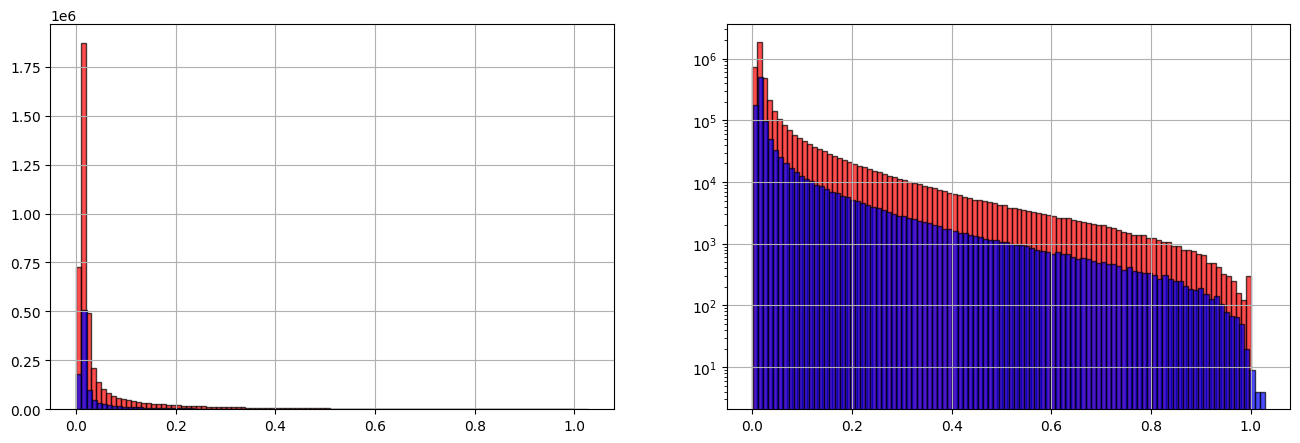

In [32]:
# sanity check 
a = 0.7
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.hist(dataset.HR_data.numpy().reshape(-1), bins=100, color="red", edgecolor="black", alpha=a, label="HR")
plt.hist(dataset.LR_data.numpy().reshape(-1), bins=100, color="blue", edgecolor="black", alpha=a, label="LR")
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(dataset.HR_data.numpy().reshape(-1), bins=100, color="red", edgecolor="black", alpha=a, label="HR")
plt.hist(dataset.LR_data.numpy().reshape(-1), bins=100, color="blue", edgecolor="black", alpha=a, label="LR")
plt.yscale("log")
plt.grid()
plt.show()


In [33]:
try:
    print(f"mean_LR = {dataset.mean_LR.item()} std_LR = {dataset.std_LR.item()}")
except Exception as e:
    print(f"mean_LR = {dataset.mean_LR} std_LR = {dataset.std_LR}")


try:
    print(f"mean_HR = {dataset.mean_HR.item()} std_HR = {dataset.std_HR.item()}")
except Exception as e:
    print(f"mean_HR = {dataset.mean_HR} std_HR = {dataset.std_HR}")
    

memory_after = psutil.virtual_memory()
print(f"RAM used : {format(memory_after.used)}, RAM free : {format(memory_after.free)}, memory used : {format(memory_after.used - memory_start.used)}")

mean_LR = 0.061324529349803925 std_LR = 0.11733044683933258
mean_HR = 0.06132453307509422 std_HR = 0.11728931218385696
RAM used : 6.67GB, RAM free : 132.38MB, memory used : 34.26MB


## see some of the data

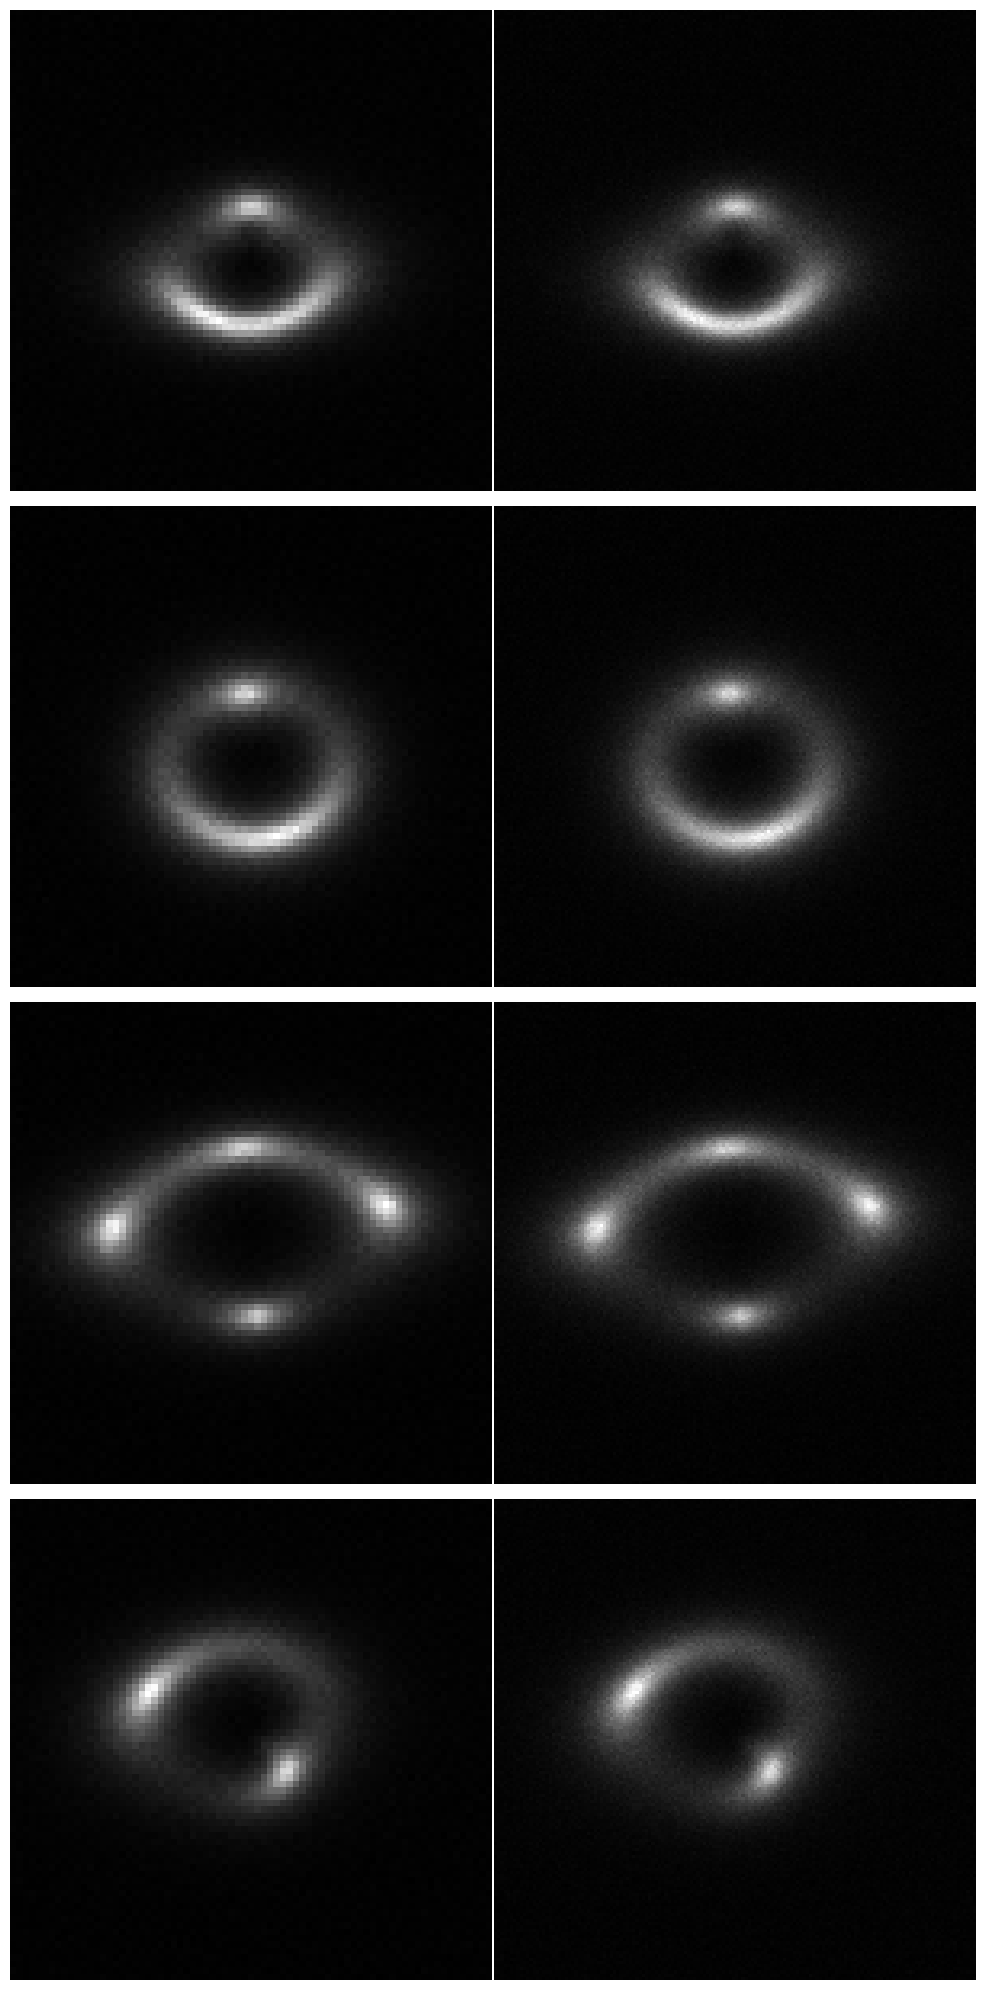

In [34]:
x, y = next(iter(val_loader))

plot_size = math.ceil(math.sqrt(CONFIG.BATCH_SIZE))

size_of_one = 5
fig, axes = plt.subplots(plot_size*plot_size, 2, figsize=(size_of_one * plot_size, size_of_one * len(x)))

for i, ax in enumerate(axes.flat):
    # Convert torch tensor to numpy array and transpose channels if necessary
    
    if i % 2 == 0:
        img = x[i//2].numpy().transpose(1, 2, 0)
        ax.imshow(img, cmap="gray")
        ax.axis('off')
    else:
        img = y[i//2].numpy().transpose(1, 2, 0)
        ax.imshow(img, cmap="gray")
        ax.axis('off')
plt.tight_layout()
plt.show()

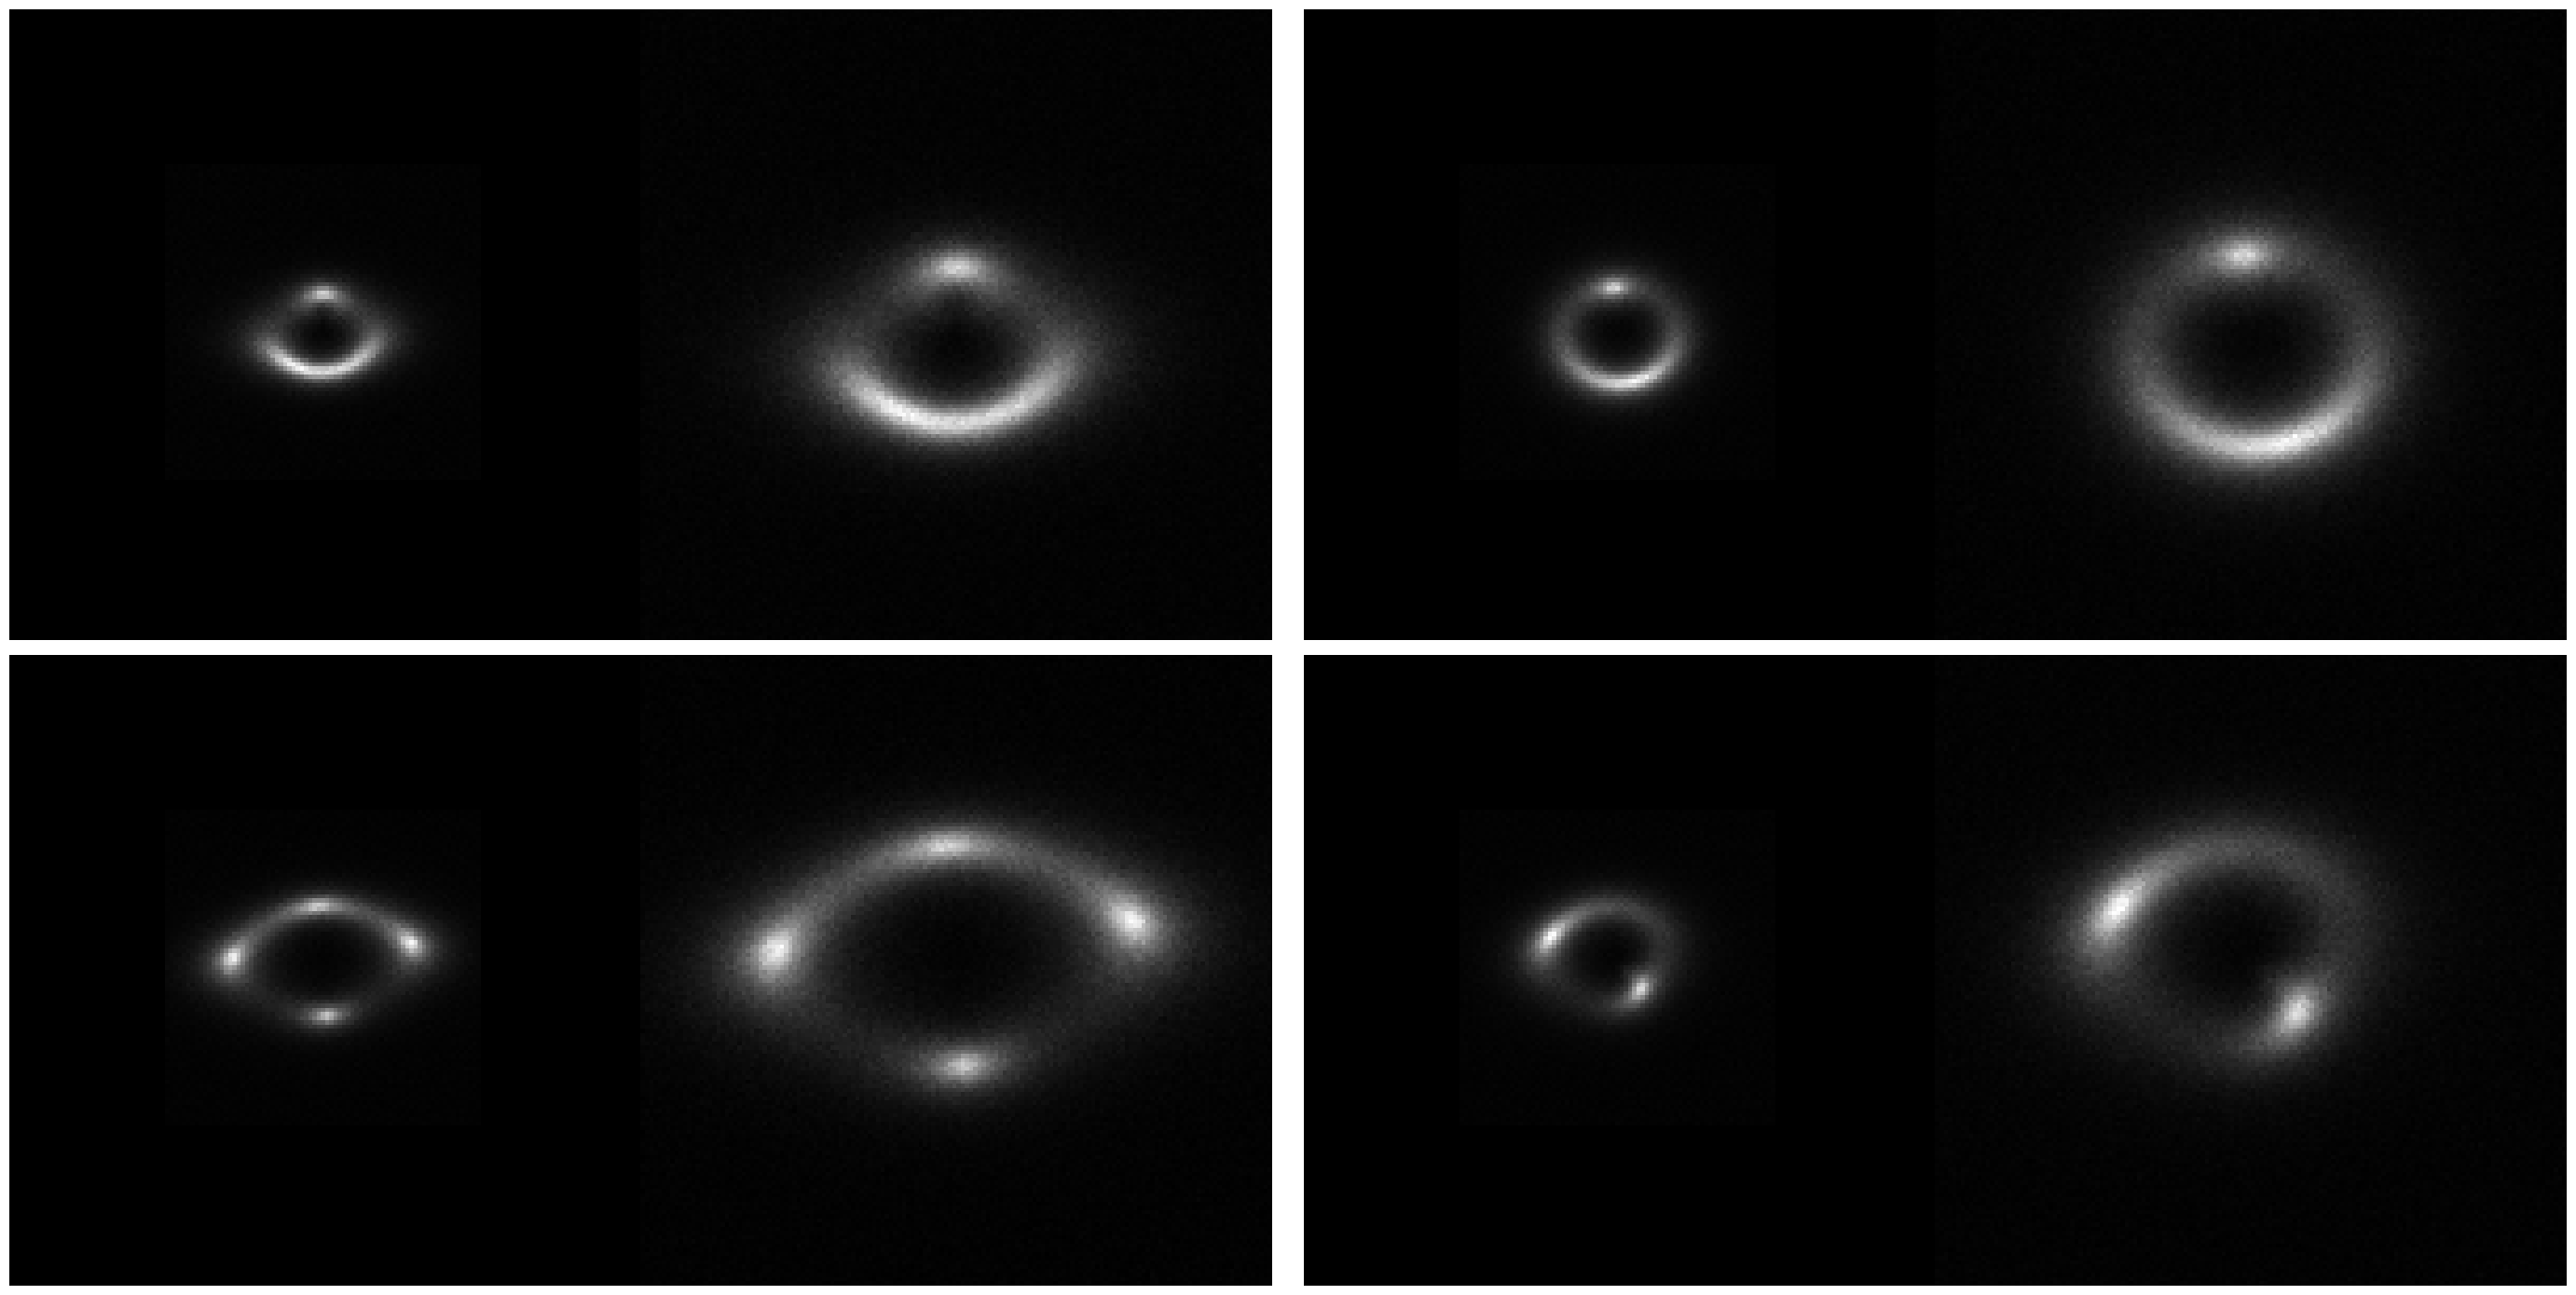

In [35]:
x, y = next(iter(val_loader))

plot_size = math.ceil(math.sqrt(CONFIG.BATCH_SIZE))

size_of_one = 7
fig, axes = plt.subplots(plot_size, plot_size, figsize=(2 * plot_size * size_of_one, plot_size * size_of_one))
center = True

for i, ax in enumerate(axes.flat):
    # Convert torch tensor to numpy array and transpose channels if necessary
    
    _LR = x[i].numpy().transpose(1, 2, 0)
    HR = y[i].numpy().transpose(1, 2, 0)
    
    LR = np.zeros_like(HR)

    offset = 0
    if center:
        offset = _LR.shape[0] // 2

    LR[offset:(offset+_LR.shape[0]),offset:(offset+_LR.shape[1])] = _LR
    
    to_plot = np.concatenate([LR, HR], axis=1)
    
    ax.imshow(to_plot, cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Simple Model

In [36]:
class SRCNN(nn.Module):
    def __init__(self) -> None:
        super(SRCNN, self).__init__()
        # Feature extraction layer.
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, (9, 9), (1, 1), (4, 4)),
            nn.ReLU(True)
        )

        # Non-linear mapping layer.
        self.map = nn.Sequential(
            nn.Conv2d(128, 64, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True)
        )

        # Rebuild the layer.
        self.reconstruction = nn.Conv2d(32, 1, (5, 5), (1, 1), (2, 2))

        # Initialize model weights.
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        print(out.shape)
        out = self.map(out)
        print(out.shape)
        out = self.reconstruction(out)
        print(out.shape)
        return out

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                nn.init.zeros_(module.bias.data)

        nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
        nn.init.zeros_(self.reconstruction.bias.data)

In [37]:
import torch.nn.functional as F

class SRCNN(nn.Module):
    def __init__(self, upscale_factor=2):
        super(SRCNN, self).__init__()
        # Upsample layer - using nn.Upsample for simplicity here, but there are other options like nn.ConvTranspose2d
        self.upsample = nn.Upsample(scale_factor=upscale_factor, mode='bilinear', align_corners=False)

        # First convolution layer with 64 filters of size 9x9
        self.conv1 = nn.Conv2d(1, 128, kernel_size=9, padding=4)
        # Second convolution layer with 32 filters of size 1x1
        self.conv2 = nn.Conv2d(128, 64, kernel_size=1, padding=0)
        # Third convolution layer with output depth as 1 (since we're assuming grayscale images) of size 5x5
        self.conv3 = nn.Conv2d(64, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.upsample(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    
model = SRCNN(upscale_factor=2)
print(model)
print(summary(model, input_size=(CONFIG.BATCH_SIZE, 1, 75, 75)))

SRCNN(
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (conv1): Conv2d(1, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)
Layer (type:depth-idx)                   Output Shape              Param #
SRCNN                                    [4, 1, 150, 150]          --
├─Upsample: 1-1                          [4, 1, 150, 150]          --
├─Conv2d: 1-2                            [4, 128, 150, 150]        10,496
├─Conv2d: 1-3                            [4, 64, 150, 150]         8,256
├─Conv2d: 1-4                            [4, 1, 150, 150]          1,601
Total params: 20,353
Trainable params: 20,353
Non-trainable params: 0
Total mult-adds (G): 1.83
Input size (MB): 0.09
Forward/backward pass size (MB): 138.96
Params size (MB): 0.08
Estimated Total Size (MB): 139.13


# Utils

In [38]:
# code ref : https://github.com/Lornatang/SRCNN-PyTorch
import warnings
import cv2
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM


def bgr2ycbcr(image: np.ndarray, only_use_y_channel: bool) -> np.ndarray:
    if only_use_y_channel:
        image = np.dot(image, [24.966, 128.553, 65.481]) + 16.0
    else:
        image = np.matmul(image, [[24.966, 112.0, -18.214], [128.553, -74.203, -93.786], [65.481, -37.797, 112.0]]) + [
            16, 128, 128]

    image /= 255.
    image = image.astype(np.float32)

    return image

def expand_y(image: np.ndarray) -> np.ndarray:
    # Normalize image data to [0, 1]
    image = image.astype(np.float32) / 255.

    # Convert BGR to YCbCr, and extract only Y channel
    y_image = bgr2ycbcr(image, only_use_y_channel=True)

    # Expand Y channel
    y_image = y_image[..., None]

    # Normalize the image data to [0, 255]
    y_image = y_image.astype(np.float64) * 255.0

    return y_image

# The following is the implementation of IQA method in Python, using CPU as processing device
def _check_image(raw_image: np.ndarray, dst_image: np.ndarray):
    # check image scale
    assert raw_image.shape == dst_image.shape, \
        f"Supplied images have different sizes {str(raw_image.shape)} and {str(dst_image.shape)}"

    # check image type
    if raw_image.dtype != dst_image.dtype:
        warnings.warn(f"Supplied images have different dtypes{str(raw_image.shape)} and {str(dst_image.shape)}")


def psnr(raw_image: np.ndarray, dst_image: np.ndarray) -> float:
    psnr_metrics = 10 * np.log10((255.0 ** 2) / np.mean((raw_image - dst_image) ** 2) + 1e-8)
    return psnr_metrics


# Learning

In [39]:
class Metric: 
    def __init__(self) -> None:
        self.name = "metric_name"
        self.average = False
    
    def eval(y_pred : torch.Tensor, y : torch.Tensor) -> float:
        raise NotImplemented("")

class MSE_Metric(Metric):
    def __init__(self) -> None:
        super().__init__()
        self.name = "Mean Squared Error (MSE)"
        self.average = True
        
    def eval(self, y_pred : torch.Tensor, y : torch.Tensor) -> float:
        return torch.mean((y_pred.cpu() - y.cpu())**2).item()
    
class PSNR_Metric(Metric):
    def __init__(self, crop_border=0) -> None:
        super().__init__()
        self.crop_border = crop_border
        self.name = "PSNR"
        self.average = True
        
    def eval(self, y_pred : torch.Tensor, y : torch.Tensor) -> float:   
        return psnr(255*y_pred.detach().cpu().numpy(), 255*y.detach().cpu().numpy())
    
class SSIM_Metric(Metric):
    def __init__(self) -> None:
        super().__init__()
        self.name = "SSIM"
        self.average = True
    
    def eval(self, y_pred : torch.Tensor, y : torch.Tensor) -> float:
        return ssim(y_pred.detach().cpu(), y.detach().cpu(), data_range=1)

In [40]:
x,y = next(iter(train_loader))
print(x.shape, y.shape)
out = model(x.to(CONFIG.DEVICE))
print(out.shape)

# test whether the metrics are working
metrics = [MSE_Metric(), PSNR_Metric(), SSIM_Metric()]
for el in range(CONFIG.BATCH_SIZE):
    xs, ys = torch.stack([out[el]]), torch.stack([y[el]])
    for metric in metrics:
        print(f"name : {metric.name}")
        print("res : ", metric.eval(xs.to(CONFIG.DEVICE), ys.to(CONFIG.DEVICE)))

torch.Size([4, 1, 75, 75]) torch.Size([4, 1, 150, 150])
torch.Size([4, 1, 150, 150])
name : Mean Squared Error (MSE)


res :  0.013490683399140835
name : PSNR
res :  18.699660188007282
name : SSIM
res :  tensor(-0.0579)
name : Mean Squared Error (MSE)
res :  0.012101230211555958
name : PSNR
res :  19.17170470022708
name : SSIM
res :  tensor(-0.0492)
name : Mean Squared Error (MSE)
res :  0.0103086456656456
name : PSNR
res :  19.867984160197064
name : SSIM
res :  tensor(-0.0590)
name : Mean Squared Error (MSE)
res :  0.01731315441429615
name : PSNR
res :  17.6162375976513
name : SSIM
res :  tensor(-0.0494)


In [44]:
from typing import List

def test(model : nn.Module, val_dataset : DataLoader, cfg : CONFIG, metrics : List[Metric], test_params : Dict[str, int] = {"save_in_total" : None, "save_every" : 0} ,  run = None):        
    # change the model to evaluation
    model.eval()
    
    # get the number of datapoints
    number_of_datapoints = len(val_dataset.dataset)    

    # allocate the memory for these datapoints (no need to keep appending the data, which will make it slower)
    metrics_names = [metric.name for metric in metrics]
    metrics_vals = np.zeros((number_of_datapoints, len(metrics_names)))

    save_images_every = 0
    if "save_in_total" in test_params and test_params["save_in_total"] is not None and test_params["save_in_total"] > 0:
        save_images_every = number_of_datapoints // test_params["save_in_total"]
        
    elif "save_every" in test_params:
        save_images_every = test_params["save_every"]

    if save_images_every > 0:
        saved_images_pred = np.zeros((number_of_datapoints // save_images_every, 150, 150, 1))
        saved_images_true = np.zeros((number_of_datapoints // save_images_every, 150, 150, 1))
        img_c = 0
    
    # get the number of batches
    dataset_len = len(val_dataset)

    # create the progreess bar 
    pbar = tqdm(val_dataset)

    # variable that will track where we are in terms of all data (after iteration add batch size to it)
    c = 0
    for i, (x,y) in enumerate(pbar): 
        # get the predictions
        pred = model(x.to(CONFIG.DEVICE))
 
        # get the batch size
        bs = x.shape[0]

        # calculate the metric for every image in the batch:
        for img_i in range(bs):
            y_pred, y_ = pred[img_i], y[img_i]
            for j, metric in enumerate(metrics):
                metrics_vals[c, j] = metric.eval(torch.stack([y_pred.cpu()]), torch.stack([y_.cpu()]))
                
            if save_images_every > 0 and c % save_images_every == 0:
                saved_images_pred[img_c] = y_pred.detach().cpu().numpy().transpose(1, 2, 0)
                saved_images_true[img_c] = y_.detach().cpu().numpy().transpose(1, 2, 0)
                img_c += 1
                
            c += 1
                  
        if i % max((dataset_len//10),1) == 0 or i == dataset_len -1:
            s = ""

            for i,metric in enumerate(metrics):
                if metric.average:
                    s += f"{metric.name}={np.mean(metrics_vals[:(c-1), i])} ; "

            pbar.set_description(f"examples seen so far : {c} " + s)
 
    ret = {}
    
    for i,metric in enumerate(metrics):
        ret[metric.name] = metrics_vals[:, i]   
        
    if save_images_every > 0:
        ret["img_pred"] = saved_images_pred
        ret["img_true"] = saved_images_true
    
    return ret 

def report_metrics(results : Dict, epoch : int, metrics : List[Metric], WANDB_ON : bool = True, prefix="val", run=None) -> Dict:
    
    ret = {}
    for metric in metrics:
        if metric.average:
            avg = np.average(results[metric.name])
            name_to_save = f"{prefix}_{metric.name}"
            ret[name_to_save] = avg

            if WANDB_ON:
                wandb.log({name_to_save : avg})
    
    if "img_pred" in results and "img_true" in results:
        size = results["img_pred"].shape
        imgs = []
        
        for b in range(size[0]):
            img = np.concatenate([results["img_pred"][b], results["img_true"][b]], axis=1)
            img_to_save = wandb.Image(img, caption="Left: predicted, right : true")
            wandb.log({f"Epoch={epoch}" : img_to_save})
            
    return ret

def save_model(model : nn.Module, metrics_results : Dict, metric_keyword : str, best_metric : float, savepath : str):
    
    if metrics_results[metric_keyword] > best_metric:
        torch.save(model.state_dict(), savepath)
        
    return max(metrics_results[metric_keyword], best_metric)

def train(train_dataloader : torch.utils.data.DataLoader, 
          model : nn.Module, 
          optimizer : optim.Optimizer, 
          scheduler : lr_sched.LRScheduler, 
          criterion, 
          epoch : int, 
          cfg : CONFIG,
          WANDB_ON : bool=True):
    model.train()
    running_loss = 0.0
    i = 1
    train_len = len(train_dataloader)
    
    pb = tqdm(train_dataloader)
    for inputs, labels in pb:
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs.to(cfg.DEVICE))
        loss = criterion(outputs, labels.to(cfg.DEVICE))
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()  # Update learning rate
        
        running_loss += loss.item()
        
        if (i-1) % max((train_len//10),1) == 0 or i == train_len:      
            pb.set_description(f"EPOCH : {epoch}, average loss : {running_loss / i}")
        i += 1
    
    if WANDB_ON:
        wandb.log({"loss" : running_loss/len(train_dataloader)})
 
def run_experiment(train_dataloader : torch.utils.data.DataLoader,
                   val_dataloader : torch.utils.data.DataLoader,
                   Model : nn.Module, 
                   run_name : str, 
                   model_parameters : dict, 
                   epochs : int, 
                   learning_rate : float, 
                   optimizer : str, 
                   savepath : str,
                   cfg : CONFIG,
                   loss : str = "MSE",
                   test_params : Dict = {"save_in_total" : 50},
                   base_lr:float=1e-4, 
                   max_lr:float=1e-3, 
                   metrics : List[Metric] = [MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
                   scheduler_en : bool = True,
                   metric_keyword : str = "acc",
                   lr_steps : int = 1000,
                   WANDB_ON : bool = True,
                   start_with_test : bool  = True):

    try:
        os.mkdir("models") 
    except FileExistsError:
        pass
    
    model = Model(**model_parameters).to(cfg.DEVICE)
    
    config = {"model name" : model.__class__,
              "run name" : run_name,
              "epochs" : epochs,
              "learning rate" : learning_rate,
              "optimizer" : optimizer, 
              "uses scheduler" : scheduler_en,
              "base_lr" : base_lr,
              "max_lr" : max_lr,
              "lr_steps" : lr_steps}
    
    config.update(model_parameters)    
    
    model_summary_str = str(summary(model, input_size=(cfg.BATCH_SIZE, 1, 150, 150)))
        
    if WANDB_ON:
        run = wandb.init(project=cfg.TASK_NAME,
                     name=f"experiment_{run_name}",
                     notes="Model summary : \n" + model_summary_str,
                     config=config)


    if loss.lower() == "mse":         
        criterion = nn.MSELoss()
    else:
        raise Exception("specify correctly the loss function")
    
    # Observe that all parameters are being optimized
    if optimizer.lower() == "adam":
        optimizer_ = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer.lower() == "adamw":
        optimizer_ = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        raise Exception("specify correctly the optimizer !")

    # Set up CyclicLR scheduler
    scheduler = None
    if scheduler_en:
        scheduler = lr_sched.CyclicLR(optimizer_, base_lr=base_lr, max_lr=max_lr, step_size_up=lr_steps, mode='triangular')

    best_metric = 0 
    
    # it was useful for superresolution, to have some starting point, to see how much it improved
    if start_with_test:
        test_res = test(model, train_dataloader, cfg=cfg, test_params=test_params,  metrics=metrics)
        evaluation = report_metrics(test_res, epoch=-1, metrics=metrics, prefix="train", WANDB_ON=WANDB_ON)
        
        test_res = test(model, val_dataloader, cfg=cfg, test_params=test_params,  metrics=metrics)
        evaluation = report_metrics(test_res, epoch=-1, metrics=metrics, prefix="val", WANDB_ON=WANDB_ON)


    for epoch in range(epochs):
        train(train_dataloader, model, optimizer_, scheduler, criterion, epoch=epoch, WANDB_ON=WANDB_ON, cfg=cfg)

        test_res = test(model, train_dataloader, cfg=cfg, test_params=test_params,  metrics=metrics)
        evaluation = report_metrics(test_res, epoch=epoch, metrics=metrics, prefix="train", WANDB_ON=WANDB_ON)
        
        test_res = test(model, val_dataloader, cfg=cfg, test_params=test_params,  metrics=metrics)
        evaluation = report_metrics(test_res, epoch=epoch, metrics=metrics, prefix="val", WANDB_ON=WANDB_ON)

        best_metric = save_model(model, evaluation, metric_keyword, best_metric, savepath)
    
    if WANDB_ON:
        wandb.finish()

In [45]:
run_experiment(train_dataloader=train_loader, 
               val_dataloader=val_loader, 
               Model=SRCNN, 
               run_name="SRCNN", 
               model_parameters={}, 
               epochs=10,
               learning_rate=1e-4, 
               optimizer='adam',
               savepath="models/srcnn.pth",
               metrics=[MSE_Metric(), PSNR_Metric(), SSIM_Metric()],
               cfg=CONFIG,
               loss="MSE",
               base_lr=1e-4, 
               test_params={"save_in_total" : 10},
               max_lr=1e-3,
               scheduler_en=False,
               metric_keyword="val_PSNR",
               lr_steps=len(dataset) // 2,
               start_with_test=True,
               WANDB_ON=True)

examples seen so far : 160 Mean Squared Error (MSE)=0.015204901273989078 ; PSNR=18.397440975858114 ; SSIM=0.6110679034916859 ; : 100%|██████████| 40/40 [00:01<00:00, 28.56it/s]
examples seen so far : 40 Mean Squared Error (MSE)=0.014863442247494673 ; PSNR=18.482126003167448 ; SSIM=0.6170540788234808 ; : 100%|██████████| 10/10 [00:00<00:00, 23.43it/s]
EPOCH : 0, average loss : 0.005245827108592493: 100%|██████████| 40/40 [00:00<00:00, 81.72it/s] 
examples seen so far : 160 Mean Squared Error (MSE)=0.0005313319872710385 ; PSNR=32.936470997520416 ; SSIM=0.7797655317018617 ; : 100%|██████████| 40/40 [00:00<00:00, 51.28it/s]
examples seen so far : 40 Mean Squared Error (MSE)=0.0005238818509193758 ; PSNR=32.97850074847013 ; SSIM=0.7809035258415418 ; : 100%|██████████| 10/10 [00:00<00:00, 45.42it/s] 
EPOCH : 1, average loss : 0.00037902789918007327: 100%|██████████| 40/40 [00:00<00:00, 128.95it/s]
examples seen so far : 160 Mean Squared Error (MSE)=0.00025820176270146086 ; PSNR=36.08444324683

loss,█▁▁▁▁▁▁▁▁▁
train_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▆▇▇▇██████
train_SSIM,▁▄█████████
val_Mean Squared Error (MSE),█▁▁▁▁▁▁▁▁▁▁
val_PSNR,▁▆▇▇▇██████
val_SSIM,▁▄█████████
loss,8e-05
train_Mean Squared Error (MSE),8e-05
train_PSNR,40.791
train_SSIM,0.96658
